In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load the data
df_wind = pd.read_csv('wind.csv')
df_wind.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70176 entries, 0 to 70175
Data columns (total 13 columns):
 #   Column                                         Non-Null Count  Dtype  
---  ------                                         --------------  -----  
 0   Time(year-month-day h:m:s)                     70176 non-null  object 
 1   Wind speed at height of 10 meters (m/s)        70176 non-null  float64
 2   Wind direction at height of 10 meters (˚)      70176 non-null  float64
 3   Wind speed at height of 30 meters (m/s)        70176 non-null  float64
 4   Wind direction at height of 30 meters (˚)      70176 non-null  float64
 5   Wind speed at height of 50 meters (m/s)        70176 non-null  float64
 6   Wind direction at height of 50 meters (˚)      70176 non-null  float64
 7   Wind speed - at the height of wheel hub (m/s)  70176 non-null  float64
 8   Wind speed - at the height of wheel hub (˚)    70176 non-null  float64
 9   Air temperature  (°C)                          701

In [3]:
# extract the data of each hour
df_wind = df_wind[df_wind.index%4==0]

In [4]:
# change the column names
df_wind.columns = ['time', 'speed_10m', 'direction_speed_10m',
                   'speed_30m', 'direction_speed_30m',
                   'speed_50m', 'direction_speed_50m',
                   'speed_hub', 'direction_speed_hub',
                   'temperature', 'atmosphere', 'humidity', 'power']

# drop the time column
df_wind.drop(columns=['time'], inplace=True)

In [5]:
# split the data into train set and test set
train_df = df_wind[:14000]
valid_df = df_wind[14000:15750]
test_df = df_wind[15750:17500]

print(train_df.shape, valid_df.shape, test_df.shape)

(14000, 12) (1750, 12) (1750, 12)


In [6]:
# min-max scale or not ?

train_df_normalized = train_df.values
valid_df_normalized = valid_df.values
test_df_normalized = test_df.values

In [7]:
# make the dataset

class WindDataset(Dataset):
    def __init__(self, data):

        self.x_data = data[:, :-1]
        self.y_data = data[:, [-1]]
        self.len = len(data)
        self.x_data = torch.tensor(self.x_data, dtype=torch.float32)
        self.y_data = torch.tensor(self.y_data, dtype=torch.float32)

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

train_dataset = WindDataset(train_df_normalized)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)

valid_dataset = WindDataset(valid_df_normalized)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=False, drop_last=True)

test_dataset = WindDataset(test_df_normalized)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class DNN(nn.Module):
    def __init__(self, input_size=11):
        super().__init__()

        self.input_size = input_size

        self.nn = torch.nn.Sequential(
            nn.Linear(self.input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        x = self.nn(x)
        return x

model = DNN()
model.to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [9]:
# train

valid_loss = 1e10

for epoch in range(50):

    model.train()
    total_loss = 0

    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        y_pred = model(inputs)
        optimizer.zero_grad()
        loss = criterion(y_pred, labels)
        total_loss+= loss.item()
        loss.backward()
        optimizer.step()
    print(f'Epoch: {epoch+1}; Train Loss: {total_loss/len(train_loader)}.')

    model.eval()

    pres_all = []
    labels_all = []

    for data in valid_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        preds = model(inputs)
        pres_all.append(preds)
        labels_all.append(labels)

    pres_new = torch.cat(pres_all, dim=0)
    labels_new = torch.cat(labels_all, dim=0)
    mse = criterion(pres_new, labels_new)

    print(f'Epoch: {epoch+1}; Valid Loss: {mse.item()}.')

    if mse < valid_loss:
        valid_loss = mse
        torch.save(model.state_dict(), 'model.pth')

print(f'Training finished.')

Epoch: 1; Train Loss: 284.4906173548928.
Epoch: 1; Valid Loss: 130.90692138671875.
Epoch: 2; Train Loss: 104.41575458011583.
Epoch: 2; Valid Loss: 150.77537536621094.
Epoch: 3; Train Loss: 97.27629975377832.
Epoch: 3; Valid Loss: 163.67340087890625.
Epoch: 4; Train Loss: 93.81524784777748.
Epoch: 4; Valid Loss: 117.5338363647461.
Epoch: 5; Train Loss: 88.2500889994187.
Epoch: 5; Valid Loss: 130.32431030273438.
Epoch: 6; Train Loss: 89.9858663851391.
Epoch: 6; Valid Loss: 156.3883514404297.
Epoch: 7; Train Loss: 90.22560564822409.
Epoch: 7; Valid Loss: 133.28445434570312.
Epoch: 8; Train Loss: 87.96328991556058.
Epoch: 8; Valid Loss: 150.4654541015625.
Epoch: 9; Train Loss: 86.14532007178126.
Epoch: 9; Valid Loss: 205.04737854003906.
Epoch: 10; Train Loss: 83.28509036572629.
Epoch: 10; Valid Loss: 142.9087677001953.
Epoch: 11; Train Loss: 84.47527001378738.
Epoch: 11; Valid Loss: 158.34616088867188.
Epoch: 12; Train Loss: 86.8647533783378.
Epoch: 12; Valid Loss: 140.5118865966797.
Epoch

In [10]:
# test

model = DNN()
model.load_state_dict(torch.load('model.pth'))
model.to(device)

model.eval()

pres_all = []
labels_all = []

for data in test_loader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)
    preds = model(inputs)
    pres_all.append(preds)
    labels_all.append(labels)

pres_new = torch.cat(pres_all, dim=0)
labels_new = torch.cat(labels_all, dim=0)

pred_outputs = pres_new.cpu().detach().numpy().reshape(-1, 1)
labels_outputs = labels_new.cpu().detach().numpy().reshape(-1, 1)

mse = mean_squared_error(pred_outputs, labels_outputs)
r_2 = r2_score(pred_outputs, labels_outputs)
mae = mean_absolute_error(pred_outputs, labels_outputs)

print(mae, mse, r_2)

6.307986 146.0151 0.750590776884097


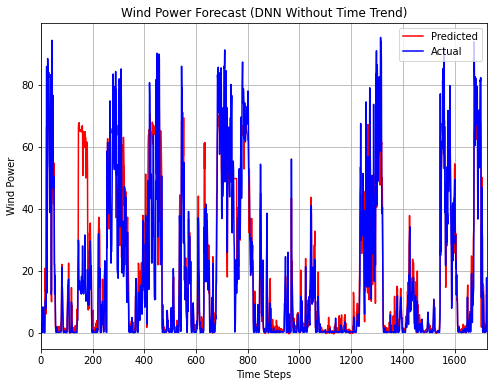

In [11]:
x = np.arange(len(pred_outputs))

plt.figure(figsize=(8, 6))
plt.title('Wind Power Forecast (DNN Without Time Trend)')
plt.ylabel('Wind Power')
plt.xlabel('Time Steps')
plt.grid(True)

plt.autoscale(axis='x', tight=True)
plt.plot(x, pred_outputs, color='r')
plt.plot(x, labels_outputs, color='b')
plt.legend(['Predicted', 'Actual'], loc='upper right')
plt.show()

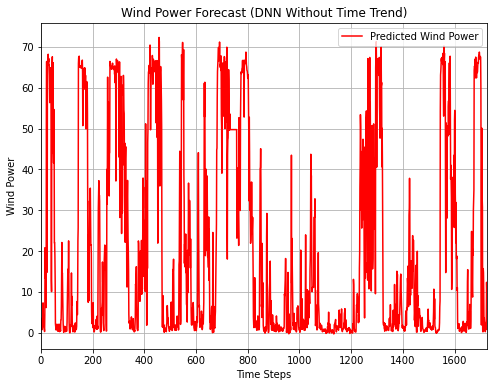

In [12]:
x = np.arange(len(pred_outputs))

plt.figure(figsize=(8, 6))
plt.title('Wind Power Forecast (DNN Without Time Trend)')
plt.ylabel('Wind Power')
plt.xlabel('Time Steps')
plt.grid(True)

plt.autoscale(axis='x', tight=True)
plt.plot(x, pred_outputs, color='r')
plt.legend(['Predicted Wind Power'], loc='upper right')
plt.show()

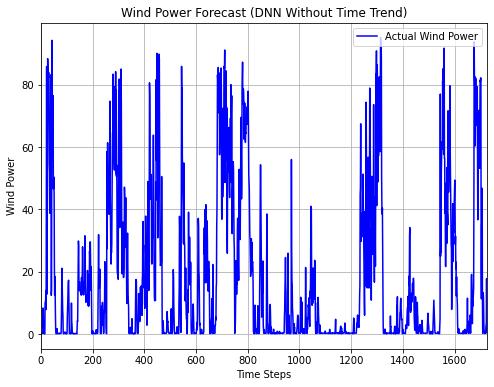

In [13]:
x = np.arange(len(labels_outputs))

plt.figure(figsize=(8, 6))
plt.title('Wind Power Forecast (DNN Without Time Trend)')
plt.ylabel('Wind Power')
plt.xlabel('Time Steps')
plt.grid(True)

plt.autoscale(axis='x', tight=True)
plt.plot(x, labels_outputs, color='b')
plt.legend(['Actual Wind Power'], loc='upper right')
plt.show()